# Title: Transpiling Optimization via Templates Matching

We implemented a pre-simplification method to improve circuit depth and error suppression. 

## Notebook Settings

In [124]:
# Import necessary modules for this notebook
import qiskit
from qiskit import QuantumCircuit
print(qiskit.__version__)

2.1.0


In [ ]:
#standard library for data manipulation
import numpy as np

In [ ]:
#module to do mapping from circuit to string
from qiskit.qasm2 import dumps

In [ ]:
#self-made library for template matching routine
import importlib
import templates as tm

importlib.reload(tm)

<module 'file_gio.templates_gio' from '/Users/giovanniconcheri/Desktop/qiskit_hackaton/file_gio/templates_gio.py'>

# INTRODUCTION

To enhance the current capabilities of the Qiskit transpiler, we developed a multi-stage optimization framework. Our approach is structured into three phases: a pre-transpilation step, a custom intermediate optimization based on ZX calculus, and a final post-transpilation step. Although we analyzed each phase independently across various circuit types, the full process can be integrated into a single, cohesive transpilation pipeline.

The first stage focuses on an initial simplification of the circuit for three-qubit gates based on templates matching. 

In the second stage, we adopted a simplification strategy based on ZX calculus as an alternative to the standard qiskit transpile optimizer and verified that it is compatible with standard error mitigation techniques.

The third stage is an additional transpilation step. There, we take the transpiled circuit and we further optimize it by permuting the qubits in a way that is both optimal with respect to the given error rates of all two-qubit gates, and allowed on hardware. For example, if the transpiled circuit simply performs an ECR gate on two qubits of the hardware, our method will select the pair of connected qubits whose corresponding ECR gate is least faulty. The method can be used to arbitrary circuits.

## CHAPTER 1: PRE-TRANSPILING OPTIMIZATION VIA TEMPLATES MATCHING

### 1A) Templates-matching

The first stage focuses on improving the "init" stage of the transpiler, which typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates. In particular, focusing on the translation of three-qubit gates into fewer qubit gates, even the optimized transpiler provided by Qiskit struggles in doing this step without increasing the circuit complexity and depth. However, restricting to circuits containing specific sequences of Toffoli and CNOT gates, we managed to significantly improve the overall transpilation for these circuits, following the original approach presented in the paper "Simplification of Toffoli Networks via Templates" https://webhome.cs.uvic.ca/~mmiller/publications/brazil03.pdf 

The templates we considered to implement our pre-transpilation process are the following:

![templates_paper](images/templates_paper.png)

**Circuit example** <br>
To see how our pre-transpilation process works, we consider a 6-register circuit with three-qubit Toffoli gates, containing the three specific templates we aim to simplify.

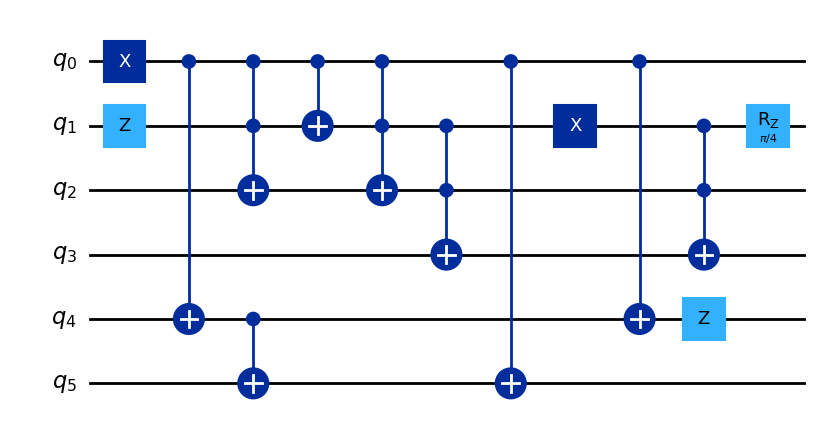

In [128]:
# we create an example of a circuit in which inside there is a template of the database

qc = QuantumCircuit(6)

qc.x(0)
# qc.ccx(4,3,1)
qc.cx(0, 4)
qc.z(1)
qc.ccx(1,0,2)
qc.cx(0, 1)
qc.ccx(0,1,2)
qc.cx(4,5)
qc.ccx(1,2,3)
qc.x(1)
qc.cx(0, 5)
qc.ccx(1, 2, 3)
qc.cx(0, 4)
qc.rz(np.pi/4, 1)
qc.z(4)


qc.draw("mpl")

**Circuit conversion** <br>
As a next step, we need to convert the circuit from Qiskit language to a more accessible format. We do it by first converting the circuit into a string using the built-in function 'dumps(circuit)', from 'qiskit.qasm2'. The string obtained is then converted into a list of lists, in which each sublist stores the information of the particular type of operation, i.e., the gate and the register qubits on which it acts. 
The list format is more accessible for us and allows us to implement a self-made search function for templates.

*Example*:<be>

| **Qiskit Circuit**                                                    | **String Format**                                                                                             | **List Format**                                    |
| --------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- | -------------------------------------------------- |
| `qc = QuantumCircuit(3)`<br>`qc.x(0)`<br>`qc.cx(0,2)`<br>`qc.ch(2,1)` | `OPENQASM 2.0;`<br>`include "qelib1.inc";`<br>`qreg q[3];`<br>`x q[0];`<br>`cx q[0],q[2];`<br>`ch q[2],q[1];` | `[['x', 0],`<br>`['cx', 0, 2],`<br>`['ch', 2, 1]]` |


In [129]:
qc_string = dumps(qc)
qc_list, qubit_num = tm.string_to_list(qc_string)

**Templates-matching routine** <br>
Now that we have the circuit in a more hand-friendly format, we can apply our self-made function to it in order to simplify it. The idea is that there will be a search function, which will scan the entire circuit searching for specific patterns suitable for simplification. Subsequently, a different function will substitute that part of the circuit with its simplified version.
An additional function will then convert the circuit back from list format to the circuit in string format and then in Qiskit format. 

*Example*:<br>
![Template matching](images/template_matching.png)


An additional future of the function is to recognise a particular template also in the case of nested gates, which do not compromise it, or for permutations of the register qubits. (explain this in a better way)

*Example*:<br>
![Equivalent circuit](images/equivalent_circuits.png)

In case nested gates break the template, it is discarded. On the other hand, if nested gates do not break the template, they are ignore.

*Example*:<br>
![Nested gates](images/nested_gates.png)
 

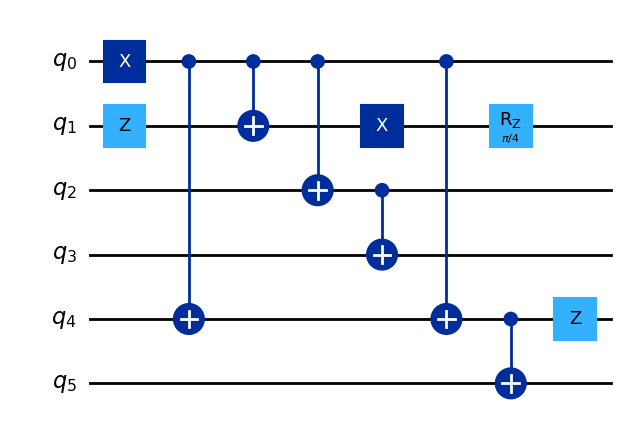

In [130]:
#pre_transpilation is the function that takes the initial circuit and returns the new circuit after the template matching
qc_reduced = tm.pre_transpilation(qc)
qc_reduced.draw("mpl")

### 1B) Transpilation routine

As a next step, we run the standard transpilation routine on two circuits: the raw one, and the one simplified with template-matching. 

In particular, we analyse two indicators to pinpoint the improved transpilation of the circuit: the circuit depth and the error rate.

To compare the circuit depth, the transpilation routine is simulated on a fake local simulator as a backend (using e.g. FakeSherbrooke()), thus introducing errors into the circuit.

Optimization level: 0
Transpilation time (sec.): 0.0073320865631103516
Circuit depth: 435
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.007581949234008789
Circuit depth: 256
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.007706165313720703
Circuit depth: 244
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.012368917465209961
Circuit depth: 247
------------------------------------------------------------------------------------------------------------------------------------------------------


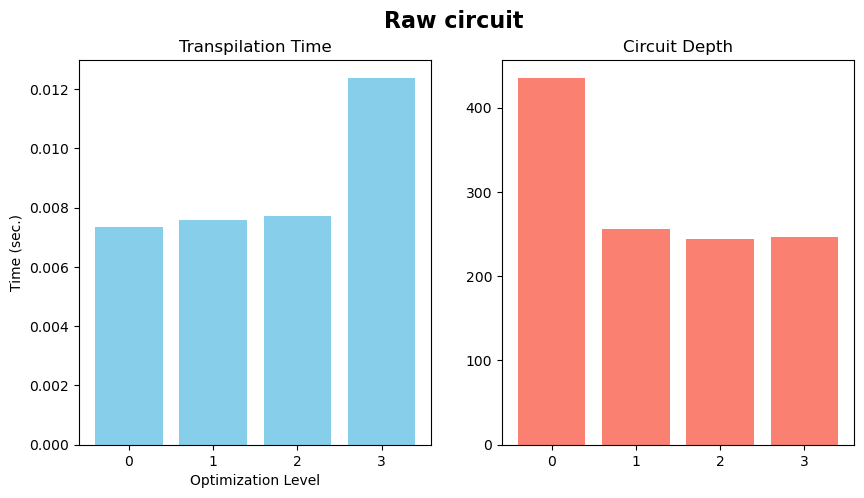

In [131]:
#Here we plot the circuit depth of the raw circuit
tm.plot_circuitdepth("FakeSherbrooke",qc, "Raw circuit")

Optimization level: 0
Transpilation time (sec.): 0.004820108413696289
Circuit depth: 107
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.004457950592041016
Circuit depth: 69
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.004668235778808594
Circuit depth: 53
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.008537054061889648
Circuit depth: 52
------------------------------------------------------------------------------------------------------------------------------------------------------


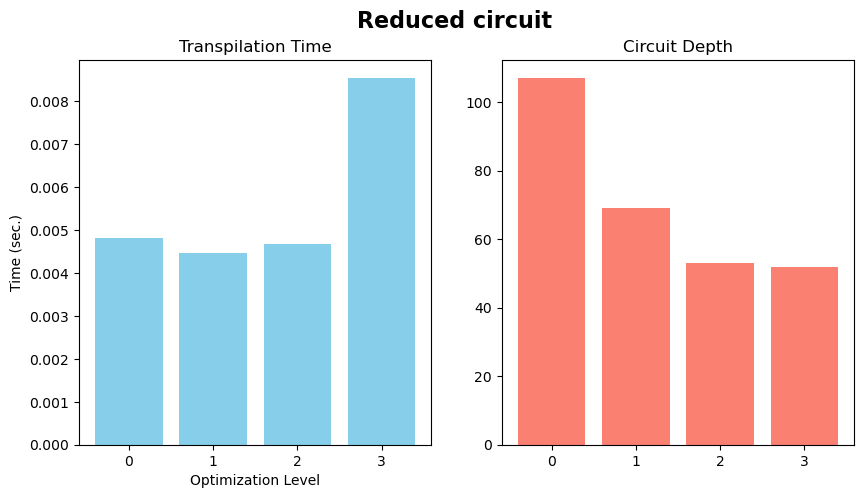

In [132]:
#Here we plot the circuit depth of the reduced circuit
tm.plot_circuitdepth("FakeSherbrooke",qc_reduced, "Reduced circuit")

As an example of the error associated to the circuits, we calculate the expectation value of Z operators $\langle Z_0 Z_j \rangle \; \forall j$, for both circuits with two backends: one corresponding to a fake local simulator (as in the previous case), and one corresponding to an ideal simulation with no errors (using AerSimulator()).

In this way, we can compare how well the two circuits with error match with the ideal case.

In [133]:
operators = tm.create_operatorstring(6)


/Users/giovanniconcheri/miniconda3/envs/QiskitHackathon/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
/Users/giovanniconcheri/miniconda3/envs/QiskitHackathon/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


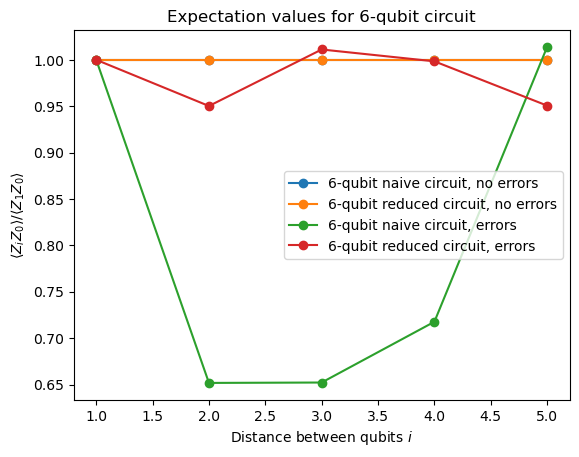

In [134]:
tm.expectation_values(operators, "FakeSherbrooke", qc, qc_reduced, 6)

As we can notice the reduced circuit with the pre-transpilation process shows an improved error suppression compared to the naive case.